In [20]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


['data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/Russian.txt', 'data/names/Japanese.txt', 'data/names/German.txt', 'data/names/Chinese.txt', 'data/names/Irish.txt']
Slusarski


In [21]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [22]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())




Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


In [58]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)        
        
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        #combine hidden and input
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)        
        output = self.i2o(combined)

        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


In [59]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))
print(input.size(), hidden.size())

output, next_hidden = rnn(input, hidden)
print(output)

torch.Size([1, 57]) torch.Size([1, 128])
Variable containing:

Columns 0 to 9 
-2.8155 -2.9146 -2.7865 -3.0059 -2.8763 -2.9108 -2.8277 -2.9307 -2.9721 -2.8429

Columns 10 to 17 
-2.8295 -2.8312 -2.9265 -2.9559 -2.8471 -2.9397 -2.8941 -2.9530
[torch.FloatTensor of size 1x18]



In [60]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))
print(input.size(), hidden.size())
output, next_hidden = rnn(input[0], hidden)
print(output)


torch.Size([6, 1, 57]) torch.Size([1, 128])
Variable containing:

Columns 0 to 9 
-2.8155 -2.9146 -2.7865 -3.0059 -2.8763 -2.9108 -2.8277 -2.9307 -2.9721 -2.8429

Columns 10 to 17 
-2.8295 -2.8312 -2.9265 -2.9559 -2.8471 -2.9397 -2.8941 -2.9530
[torch.FloatTensor of size 1x18]



In [61]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 2)


In [62]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Japanese / line = Kijimuta
category = Arabic / line = Qureshi
category = Russian / line = Chersky
category = Greek / line = Hadjiyianakies
category = French / line = Thayer
category = French / line = Bureau
category = English / line = Osmond
category = Irish / line = O'Grady
category = Polish / line = Adamczak
category = Chinese / line = Zong


In [63]:
criterion = nn.NLLLoss()

In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]


In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 1.1150 Katsourinis / Greek ✓
10000 10% (0m 26s) 1.8918 Ruadhan / Scottish ✗ (Irish)
15000 15% (0m 40s) 1.6830 Deforest / French ✓
20000 20% (0m 55s) 3.4031 Jamussa / Japanese ✗ (Greek)
25000 25% (1m 8s) 1.5827 Chong / Vietnamese ✗ (Korean)
30000 30% (1m 21s) 2.0126 Belmonte / Czech ✗ (Spanish)
35000 35% (1m 33s) 0.6198 Tong / Vietnamese ✓
40000 40% (1m 46s) 2.6267 Philips / Greek ✗ (Dutch)
45000 45% (1m 59s) 1.8835 Schorel / Czech ✗ (Dutch)
50000 50% (2m 12s) 0.3266 Spyridis / Greek ✓
55000 55% (2m 25s) 1.7296 Kappel / Czech ✗ (German)
60000 60% (2m 42s) 2.3336 Pasternack / Italian ✗ (Polish)
65000 65% (2m 54s) 1.5791 Ngo / Korean ✗ (Vietnamese)
70000 70% (3m 8s) 0.5510 Mar / Chinese ✓
75000 75% (3m 20s) 0.7626 Oursler / German ✓
80000 80% (3m 34s) 0.2087 Acciaioli / Italian ✓
85000 85% (3m 48s) 0.2926 Polites / Greek ✓
90000 90% (4m 4s) 1.8207 Chu / Vietnamese ✗ (Korean)
95000 95% (4m 18s) 0.4419 Vinh / Vietnamese ✓
100000 100% (4m 31s) 3.0331 Samson / Arabic ✗ (Frenc

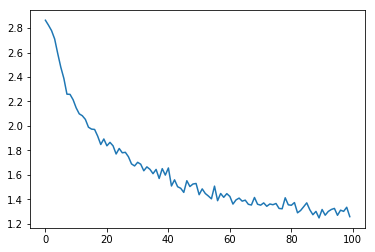

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

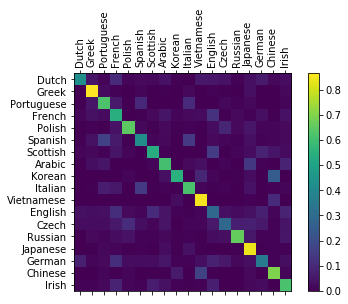

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [64]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Müller')
predict('Heinrich')


> Dovesky
(-2.76) Polish
(-2.80) Portuguese
(-2.83) Scottish

> Jackson
(-2.77) Portuguese
(-2.79) Spanish
(-2.82) Polish

> Satoshi
(-2.81) Czech
(-2.83) Polish
(-2.83) Dutch

> Müller
(-2.74) Dutch
(-2.76) Vietnamese
(-2.82) Portuguese

> Heinrich
(-2.81) Polish
(-2.82) Portuguese
(-2.83) Spanish


In [68]:
# https://discuss.pytorch.org/t/simple-working-example-how-to-use-packing-for-variable-length-sequence-inputs-for-rnn/2120
# simple packing example

batch_size = 3
max_length = 3
hidden_size = 5
n_layers =1

# container
batch_in = torch.zeros((batch_size, 1, max_length))

#data
vec_1 = torch.FloatTensor([[1, 2, 3]])
vec_2 = torch.FloatTensor([[1, 2, 0]])
vec_3 = torch.FloatTensor([[1, 0, 0]])

batch_in[0] = vec_1
batch_in[1] = vec_2
batch_in[2] = vec_3

batch_in = Variable(batch_in)

seq_lengths = [3,2,1] # list of integers holding information about the batch size at each sequence step

# pack it
pack = torch.nn.utils.rnn.pack_padded_sequence(batch_in, seq_lengths, batch_first=True)

print(pack)
# PackedSequence(data=Variable containing:
#  1  2  3
#  1  2  0
#  1  0  0
# [torch.FloatTensor of size 3x3]
# , batch_sizes=[3])


# initialize
rnn = nn.RNN(max_length, hidden_size, n_layers, batch_first=True) 
h0 = Variable(torch.randn(n_layers, batch_size, hidden_size))

#forward 
out, _ = rnn(pack, h0)

# unpack
unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out)

print(unpacked)
# Variable containing:
# (0 ,.,.) = 
#  -0.7883 -0.7972
#   0.3367 -0.6102
#   0.1502 -0.4654
# [torch.FloatTensor of size 1x3x2]


PackedSequence(data=Variable containing:
 1  2  3
 1  2  0
 1  0  0
[torch.FloatTensor of size 3x3]
, batch_sizes=[3])
Variable containing:
(0 ,.,.) = 
  0.3926 -0.8495 -0.4811  0.9903  0.4079
  0.6101 -0.8258 -0.3250  0.9193  0.0648
  0.1622 -0.3909 -0.3054  0.5123 -0.3169
[torch.FloatTensor of size 1x3x5]

